# Problem Session 2. Introduction to Python for biological circuits

<hr>

To execute Jupyter notebooks, you can either [install Jupyter locally](https://jupyter.org/install), or use the [JupyterHub of Paris-Saclay](https://jupyterhub.ijclab.in2p3.fr/). Alternatively, you can always run the Python scripts directly.

In [1]:
import numpy as np
import scipy.integrate
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline

figsize=(6, 4.5)

## Our model system

As we learn how to use some Python-based tools for analysis of genetic circuits, we will learn an important design principle about *cascades*. A three-component cascade is illustrated below.

\begin{align}
\mathrm{X} \to \mathrm{Y} \to \mathrm{Z}
\end{align}

Here, X is our input, which we will specify. X could be something like an externally imposed stimulus.  We are interested in the response of Y and Z as a function of input X. We will expose the design principle that a cascade can filter out high frequency fluctuations. This makes sense intuitively. Imagine we have a brief pulse in X. Y will start to grow in concentration during the pulse, but will then fall back toward its basal level when the pulse stops. If there is not enough time for Y to accumulate enough to enhance production of Z, then the level of Z does not change appreciably. Thus, Z shows no response to a brief pulse.

## The dynamical equations

We will model the circuit more quantitatively by writing down a system of ordinary differential equations and solving them. We will assume Hill-like behavior for the activation of Y by X and of Z by Y.  We also neglect leakage.  We define the concentrations of X, Y, and Z, respectively as $x$, $y$, and $z$.  The system of ODEs describing this system is then

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta_y\,\frac{(x/k_x)^{n_x}}{1+(x/k_x)^{n_x}} - \gamma_y y, \\[1em]
\frac{\mathrm{d}z}{\mathrm{d}t} &= \beta_z\,\frac{(y/k_y)^{n_y}}{1+(y/k_y)^{n_y}} - \gamma_z z.
\end{align}

Note that the imposed $x(t)$ is in general a function of time.  

## Nondimensionalization

As is generally a good idea for analysis of these systems, we will **nondimensionalize** the dynamical equations. The variables and parameters in the problem have **dimension**. For example, $y$ has dimension of concentration, or number of particles per cubic length, written as

\begin{align}
y = \left[\frac{N}{L^3}\right].
\end{align}

The parameter $\gamma_y$ has dimension of inverse time, or $\gamma_y = [T^{-1}]$. It is clear that each term in the dynamical equations has dimension of $N/L^3 T$. In general, every term in an equation must have the same dimension; trying to add, for example, a meter to a kilogram is nonsensical.

The nondimensionalization procedure involves rewriting the equations such that every term is **dimensionless**, which means that every term has dimension of unity. We can do this by defining dimensionless parameters as follows.

\begin{align}
\tilde{t} &= \gamma_y t, \\[2mm]
\tilde{x} &= x/k_x, \\[2mm]
\tilde{y} &= y/k_y, \\[2mm]
\tilde{z} &= \gamma_z\,z/\beta_z, \\[2mm]
\gamma &= \gamma_z/\gamma_y, \\[2mm]
\beta &= \frac{\beta_y}{\gamma_y k_y}, \\[2mm]
\end{align}

Inserting these into the dynamical equations, our dimensionless ODEs are

\begin{align}
\frac{\mathrm{d}\tilde{y}}{\mathrm{d}\tilde{t}} &= \beta\,\frac{\tilde{x}^{n_x}}{1+\tilde{x}^{n_x}} - \tilde{y}, \\[1em]
\gamma^{-1}\,\frac{\mathrm{d}\tilde{z}}{\mathrm{d}\tilde{t}} &= \frac{\tilde{y}^{n_y}}{1+\tilde{y}^{n_y}} - \tilde{z}.
\end{align}

For notational convenience, and since we will always be working in dimensionless units, we will drop the tildes.

\begin{align}
\frac{\mathrm{d}y}{\mathrm{d}t} &= \beta \,\frac{x^{n_x}}{1+x^{n_x}} - y, \\[1em]
\gamma^{-1}\,\frac{\mathrm{d}z}{\mathrm{d}t} &= \frac{y^{n_y}}{1+y^{n_y}} - z.
\end{align}

Thus, in addition to the specifics of our input $x(t)$, we have four parameters, $\beta$, $\gamma$, $n_x$, and $n_y$. Note that this is two fewer parameter than the original equations. Nondimensionalization typically results in a reduction of the number of parameters that vary independently.

## The scipy.intergrate module

**The [SciPy Library](https://docs.scipy.org/doc/scipy/reference/)** is a Python library for scientific computing. It contains many modules, including `scipy.stats`, `scipy.special`, and `scipy.optimize`, which respectively have functions to perform statistical calculations, special functions, and optimization. There are many more. We will use the `scipy.integrate` module to integrate systems of ODEs.

There are three main APIs for solving real-valued initial value problems in the module. They are [solve_ivp()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp), [ode()](https://scipy.github.io/devdocs/generated/scipy.integrate.ode.html#scipy.integrate.ode), and [odeint()](https://scipy.github.io/devdocs/generated/scipy.integrate.odeint.html#scipy.integrate.odeint). According to the SciPy developers, `solve_ivp()` is the preferred method, with the others labeled as having an "old" API. The `solve_ivp()` function has the flexibility of allowing choice of multiple numerical algorithms for solving ODEs. However, for the kinds of problems we encounter in this class, I find that the generic LSODA algorithm developed by Linda Petzold and Alan Hindmarsh that handles both stiff and non-stiff problems with variable time stepping is the best option. This is the only solver offered in the `odeint()` function. If we compare the two solvers, `solve_ivp()` and `odeint()`, the former has a large overhead, which can lead to performance issues for small problems (for large problems, this is not a big deal). Since most of our problems are small, we will use `odeint()`. It has much better performance, and though its API is different, it is still intuitive.
The basic call signature for `odeint()` is

    scipy.integrate.odeint(func, y0, t, args=())

There are many other keyword arguments to set algorithmic parameters, but we will generally not need them (and you can read about them in the [documentation](https://scipy.github.io/devdocs/generated/scipy.integrate.odeint.html#scipy.integrate.odeint)).
Importantly, `func` is a vector-valued function with call signature `func(y, t, *args)` that specifies the right hand side of the system of ODEs to be solved. `t` is a scalar time point and `y` is a one-dimensional array (though multidimensional arrays are possible). `y0` is an array with the initial conditions.

As is often the case, use of this function is best seen by example, and we will now apply it to the cascade circuit.

## Solving for a constant input X

We will first consider the case where we initially have no X, Y, or Z present. At time $t = 0$, we suddenly have a concentration of X of $x_0$. So, we need six parameters for the right hand side of our ODEs, $\beta_y$, $\beta_z$, $\gamma$, $n_x$, $n_y$, and $x_0$.

We now define the function for the right hand side of the ODEs.

In [2]:
def cascade_rhs(yz, t, beta, gamma, n_x, n_y, x):
    """
    Right hand side for cascade X -> Y -> Z.  Return dy/dt and dz/dt.
    """
    # Unpack y and z
    y, z = yz
    
    # Compute dy/dt
    dy_dt = beta * x**n_x / (1 + x**n_x) - y
    
    # Compute dz/dt
    dz_dt = gamma * (y**n_y / (1 + y**n_y) - z)
    
    # Return the result as a NumPy array
    return np.array([dy_dt, dz_dt])

We can now define the initial conditions, our parameters, and the time points we want and use `scipy.integrate.odeint()` to solve.

In [3]:
# Number of time points we want for the solutions
n = 400

# Time points we want for the solution
t = np.linspace(0, 10, n)

# Initial condition
yz_0 = np.array([0.0, 0.0])

# Parameters
beta = 1.0
gamma = 1.0
n_x = 2
n_y = 2
x0 = 2.0

# Package parameters into a tuple
args = (beta, gamma, n_x, n_y, x0)

# Integrate ODES
yz = scipy.integrate.odeint(cascade_rhs, yz_0, t, args=args)

That's it!  The integration is done.  We can now look at what `scipy.integrate.odeint()`'s output looks like.

In [4]:
yz.shape

(400, 2)

The first column of the output `yz` gives $y(t)$ at the specified time points and the second column gives $z(t)$.  We would now like to plot the results.

## Plotting results

We will use [matplotlib](http://bokeh.pydata.org/) to plot the results, more specifically `pyplot`. The syntax is not too hard learn. Just follow the examples:

In [5]:
def cascade_response_plot(
    log_beta=0,
    log_gamma=0,
    n_x=2,
    n_y=2,
    log_x0=np.log10(2),
    t_max=10,
    normalize=False,
):
    # Package parameters into a tuple
    args = (
        10 ** log_beta,
        10 ** log_gamma,
        n_x,
        n_y,
        10 ** log_x0,
    )

    # Integrate ODES
    t = np.linspace(0, t_max, 400)
    yz = scipy.integrate.odeint(cascade_rhs, yz_0, t, args=args)
    y, z = yz.transpose()

    # Normalize Y and Z responses
    if normalize:
        y /= y.max()
        z /= z.max()

        
    plt.figure(figsize=figsize)
    plt.xlabel("dimensionless time")
    plt.ylabel(f"{'normalized ' if normalize else ''}dimensionless y, z")
    plt.xlim([0, t_max])

    plt.plot(t, y, color="cornflowerblue", label="y")
    plt.plot(t, z, color="orange", label="z")
    
    plt.legend()
    plt.show()

Now that we have our function, we can generate a plot:

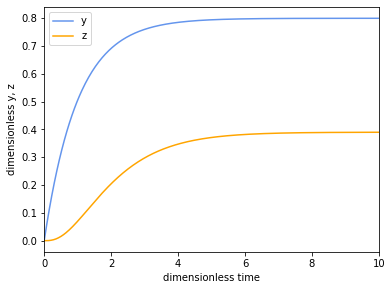

In [6]:
cascade_response_plot()

## Duration of input

Coming back to our cascade circuit, now imagine that the input is a pulse of duration $\tau$.  We can write a function for this and plot it.

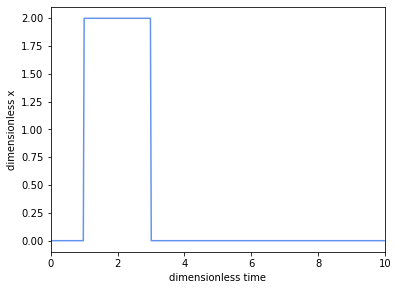

In [7]:
def x_pulse(t, t_0, tau, x_0):
    """
    Returns x value for a pulse beginning at t = 0 
    and ending at t = t_0 + tau.
    """
    return np.logical_and(t >= t_0, t <= (t_0 + tau)) * x_0


plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless x")
plt.xlim([0, 10])

plt.plot(t, x_pulse(t, 1.0, 2.0, 2), color="cornflowerblue")
    
plt.show()

If we want to solve the ODEs for a pulsed input, we need to have a way to pass this function as a parameter. Fortunately, we can pass functions as arguments in Python! So, we write a new function that takes `x_fun`, the function describing $x(t)$ as an argument, as well as `x_args`, the set of parameters passed into `x_fun`.

In [8]:
def cascade_rhs_x_fun(yz, t, beta, gamma, n_x, n_y, x_fun, x_args):
    """
    Right hand side for cascade X -> Y -> Z.  Return dy/dt and dz/dt.
    
    x_fun is a function of the form x_fun(t, *x_args), so x_args is a tuple
    containing the arguments to pass to x_fun.
    """
    # Compute x
    x = x_fun(t, *x_args)

    # Return cascade RHS with this value of x
    return cascade_rhs(yz, t, beta, gamma, n_x, n_y, x)

With this in hand, we can now solve for a pulse.  We will have a pulse during $1 \le t \le 5$.

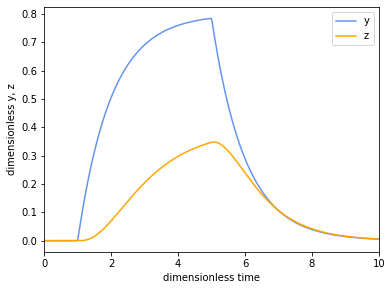

In [9]:
# Set up parameters for the pulse (on at t = 1, off at t = 5, x_0 = 2)
x_args = (1.0, 4.0, 2.0)

# Package parameters into a tuple
args = (beta, gamma, n_x, n_y, x_pulse, x_args)

# Integrate ODEs
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless y, z")
plt.xlim([0, 10])

plt.plot(t, y, color="cornflowerblue", label="y")
plt.plot(t, z, color="orange", label="z")
    
plt.legend()
plt.show()

Let's see what happens when we do a shorter pulse, this time with $1 \le t \le 1.7$.

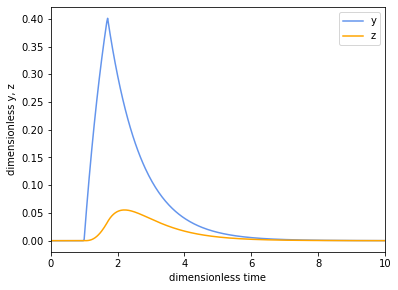

In [10]:
# Set up parameters for the pulse (on at t = 1, off at t = 1.7, x_0 = 2)
x_args = (1.0, 0.7, 2.0)

# Package parameters into a tuple
args = (beta, gamma, n_x, n_y, x_pulse, x_args)

# Integrate ODEs
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()



plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless y, z")
plt.xlim([0, 10])

plt.plot(t, y, color="cornflowerblue", label="y")
plt.plot(t, z, color="orange", label="z")
    
plt.legend()
plt.show()

We see that Z basically does not respond strongly to a short pulse.  The delay of the circuit allows short pulses to be ignored, but large pulses to be detected and responded to.

## Really short pulses and a lesson about scipy.integrate.odeint()

Now, we will take a brief interlude to learn an important lesson about the algorithm of `scipy.integrate.odeint()` and its use in these applications. We will consider a very brief pulse, $1 \le t \le 1.05$.

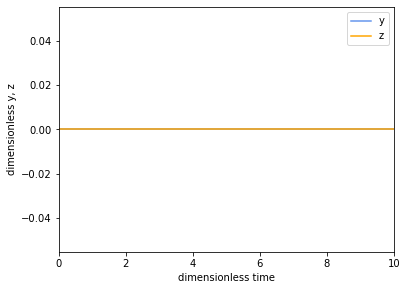

In [11]:
# Set up parameters for the pulse (on at t = 1, off at t = 1.05, x_0 = 2)
x_args = (1.0, 0.05, 2.0)

# Package parameters into a tuple
args = (beta, gamma, n_x, n_y, x_pulse, x_args)

# Integrate ODEs
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless y, z")
plt.xlim([0, 10])

plt.plot(t, y, color="cornflowerblue", label="y")
plt.plot(t, z, color="orange", label="z")
    
plt.legend()
plt.show()

Uh oh!  Something went wrong, since the Y signal never went up. This exposes an important issue with the algorithm used by `scipy.integrate.odeint()`. The Hindmarsh-Petzold algorithm uses variable step sizes so that it takes long steps when the system is not changing much and short steps when it is. Therefore, if we have a long period of no changes (leading up to $t = 1$), the step sizes taken by the solver will increase, and we'll step right over the pulse.

So, it is in general good practice to explicitly take into account discontinuities in the parameters over time. In this case, we would use `scipy.integrate.odeint()` to integrate to the pulse and use the end point of that as the initial condition of a new solution during the pulse. Then, at the end of the pulse, we start again.  Let's try again using this method.

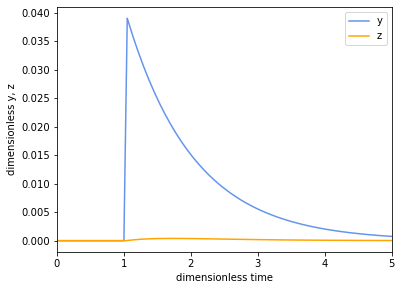

In [12]:
# Integrate prior to pulse
t_before_pulse = np.linspace(0, 1.0, 20)
args = (beta, gamma, n_x, n_y, 0.0)
yz_0 = np.array([0.0, 0.0])
yz_before_pulse = scipy.integrate.odeint(
    cascade_rhs, yz_0, t_before_pulse, args=args
)

# Integrate during pulse
t_during_pulse = np.linspace(1.0, 1.05, 50)
args = (beta, gamma, n_x, n_y, 2.0)
yz_0 = yz_before_pulse[-1]
yz_during_pulse = scipy.integrate.odeint(
    cascade_rhs, yz_0, t_during_pulse, args=args
)

# Integrate after pulse
t_after_pulse = np.linspace(1.05, 5, 50)
args = (beta, gamma, n_x, n_y, 0.0)
yz_0 = yz_during_pulse[-1]
yz_after_pulse = scipy.integrate.odeint(
    cascade_rhs, yz_0, t_after_pulse, args=args
)

# Piece together solution
t = np.concatenate((t_before_pulse, t_during_pulse[1:], t_after_pulse[1:]))
yz = np.vstack(
    (yz_before_pulse, yz_during_pulse[1:, :], yz_after_pulse[1:, :])
)
y, z = yz.transpose()


plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless y, z")
plt.xlim([0, 5])

plt.plot(t, y, color="cornflowerblue", label="y")
plt.plot(t, z, color="orange", label="z")
    
plt.legend()
plt.show()

Much better. Dealing with discontinuities like this while solving systems of ODEs are facilitated by **event handling**. Unfortunately, `scipy.integrate.odeint()` does not allow for event handling, and we need to take the less elegant approach we just showed.

Note that `scipy.integrate.solve_ivp()` *does* have event handling capabilities. However, we will seldom need event handing for our purposes, and it is still advantages to use `scipy.integrate.odeint()` due to its low overhead.

## Periodic input

Finally, we will consider the case where we have periodic forcing of the circuit. We will do this for highly cooperative activation by Y, taking $n_y = 10$. Recall that this gives a longer time delay.

We first write a function for the forcing, `x_fun`, which is periodic with frequency $f$.

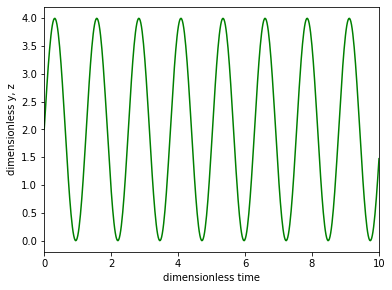

In [13]:
def x_periodic(t, f, x_0):
    """
    Returns x value for periodic forcing of amplitude x_0 and frequency f.
    """
    if type(f) in [float, int]:
        return x_0 * (1 + np.sin(f * t))
    else:
        sin_sum = np.zeros_like(t)
        for freq, amp in zip(f, x_0):
            sin_sum += amp * (1 + np.sin(freq * t))
        return sin_sum


# Plot the forcing
t = np.linspace(0, 10, 500)


plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless y, z")
plt.xlim([0, 10])

plt.plot(t, x_periodic(t, 5, 2.0), color="green")

plt.show()

Let's see how the circuit responds to a low-frequency input.

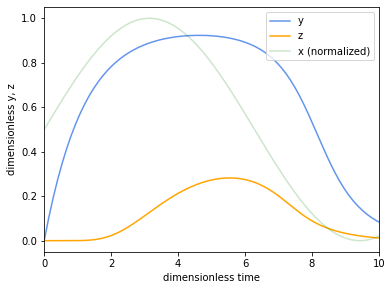

In [14]:
# Set up parameters for periodic forcing with f = 0.5 and x_0 = 2.
x_args = (0.5, 2.0)

# Package parameters into a tuple, now with high ultrasensitivity
n_y = 10
args = (beta, gamma, n_x, n_y, x_periodic, x_args)

# Time points
t = np.linspace(0, 40, 300)

# Initial condition
yz_0 = np.array([0.0, 0.0])

# Integrate ODES
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# x
x = x_periodic(t, *x_args)
x /= x.max()


plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless y, z")
plt.xlim([0, 10])

plt.plot(t, y, color="cornflowerblue", label="y")
plt.plot(t, z, color="orange", label="z")

plt.plot(t,x, color="green", alpha=0.2, label="x (normalized)")
    
plt.legend()
plt.show()

We roughly follow the forcing with some lag.  Now, for high-frequency forcing, we have a different response.

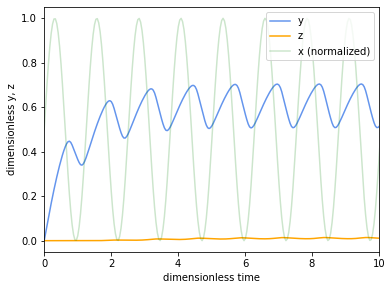

In [15]:
# Set up parameters for periodic forcing with f = 5 and x_0 = 2.
x_args = (5.0, 2.0)

# Package parameters into a tuple
args = (beta, gamma, n_x, 10, x_periodic, x_args)

# Time points
t = np.linspace(0, 25, 600)

# Initial condition
yz_0 = np.array([0.0, 0.0])

# Integrate ODES
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# x
x = x_periodic(t, *x_args)
x /= x.max()


plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless y, z")
plt.xlim([0, 10])

plt.plot(t, y, color="cornflowerblue", label="y")
plt.plot(t, z, color="orange", label="z")

plt.plot(t,x, color="green", alpha=0.2, label="x (normalized)")
    
plt.legend()
plt.show()

We see that Z does not really respond to high frequency forcing, even though the forcing is with the same amplitude. This gives us a design principle, that **a cascade can filter out high frequency fluctuations**. We can see this by adding another frequency to the signal.

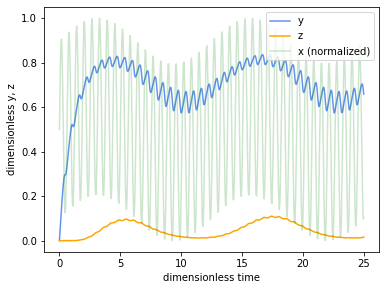

In [16]:
# Set up parameters for periodic forcing with f = 5 and x_0 = 2.
x_args = ((0.5, 10.0), (0.5, 2.0))

# Package parameters into a tuple
args = (beta, gamma, n_x, 10, x_periodic, x_args)

# Time points
t = np.linspace(0, 25, 600)

# Initial condition
yz_0 = np.array([0.0, 0.0])

# Integrate ODES
yz = scipy.integrate.odeint(cascade_rhs_x_fun, yz_0, t, args=args)

# Pluck out y and z
y, z = yz.transpose()

# x
x = x_periodic(t, *x_args)
x /= x.max()


plt.figure(figsize=figsize)
plt.xlabel("dimensionless time")
plt.ylabel(f"dimensionless y, z")

plt.plot(t, y, color="cornflowerblue", label="y")
plt.plot(t, z, color="orange", label="z")

plt.plot(t,x, color="green", alpha=0.2, label="x (normalized)")
    
plt.legend()
plt.show()

Even though the high frequency part of the forcing has a bigger amplitude, the signal in *z* responds predominantly to the low frequency part of the signal.